## GENERATIVE ADVERSARIAL NETWORK
---

### Libraries

In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchsummary import summary
from tqdm import tqdm
import torch

from functions.show_images import show_tensor_images
from functions.norm_weights import weights_init
from functions.compute_loss import real_loss, fake_loss

from classes.discriminator import Discriminator
from classes.generator import Generator

/home/fernandofincatti/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load globals

In [2]:
DEVICE="cuda"
BATCH_SIZE=128 #trainloader, train loop
NOISE_DIM=64 # generator model

#optimizers parameters
LR=0.0002
BETA_1=0.5
BETA_2=0.99

#training variables
EPOCHS=40


### Load MNIST dataset

In [3]:
train_augs = T.Compose([
    T.RandomRotation((-20, 20)),
    T.ToTensor() #(h, w, c) -> (c, h, w)
])

In [4]:
trainset = datasets.MNIST("MNIST/",
    download=True,
    train=True,
    transform=train_augs
)

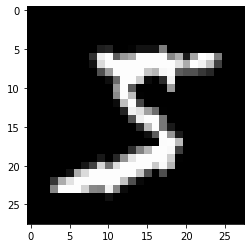

In [5]:
image, label = trainset[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.show()

### Load dataset into batches

In [6]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

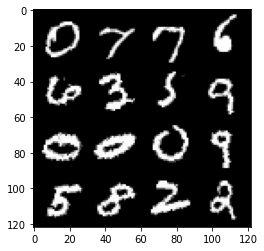

In [7]:
dataiter = iter(trainloader)
images, _ = dataiter.next()
show_tensor_images(images)

### Create discriminator

In [8]:
discriminator = Discriminator()
discriminator.to(DEVICE)

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [9]:
summary(discriminator, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

### Create generator

In [10]:
generator = Generator(NOISE_DIM)
generator.to(DEVICE)

Generator(
  (block1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

In [11]:
summary(generator, input_size=(1, NOISE_DIM))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

### Create Loss function and load optimizer

In [13]:
discriminator.get_optimizer(LR, BETA_1, BETA_2)
generator.get_optimizer(LR, BETA_1, BETA_2)

### Train loop

100%|██████████| 469/469 [00:10<00:00, 43.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1 | Disc_loss 0.6832430362701416 | Gen_loss 0.7050164937973022


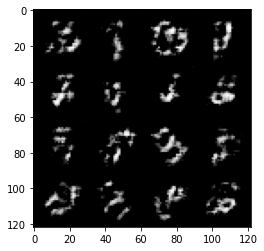

100%|██████████| 469/469 [00:10<00:00, 44.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2 | Disc_loss 0.6742687225341797 | Gen_loss 0.7179046869277954


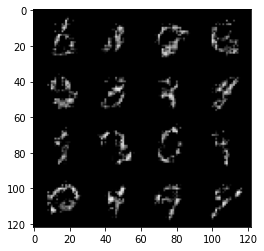

100%|██████████| 469/469 [00:10<00:00, 43.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3 | Disc_loss 0.6290901303291321 | Gen_loss 0.7708283066749573


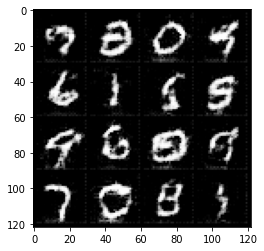

 33%|███▎      | 155/469 [00:03<00:07, 42.20it/s]


KeyboardInterrupt: 

In [15]:
for i in range(EPOCHS):
    discriminator.total_loss = 0
    generator.total_loss = 0
    for real_img, _ in tqdm(trainloader):
        real_img = real_img.to(DEVICE)
        discriminator.update(generator, BATCH_SIZE, NOISE_DIM, real_img)
        gen_images = generator.update(discriminator, BATCH_SIZE, NOISE_DIM, real_img)
    avg_disc_loss = discriminator.total_loss/len(trainloader)
    avg_gen_loss = generator.total_loss/len(trainloader)
    print("Epoch: {0} | Disc_loss {1} | Gen_loss {2}".format(i+1, avg_disc_loss, avg_gen_loss))
    show_tensor_images(gen_images)